# Predictions of Loans

## Goal:

Automate the **loan eligibility process** based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others

## Data

We have a table that contains information about loan's applicants.

**Columns:**


- **Loan_ID**: Unique Loan ID
- **Gender:** Male/ Female
- **Married:** Applicant married (Y/N)
- **Dependents:** Number of dependents
- **Education:** Applicant Education (Graduate/ Under Graduate)
- **Self_Employed:** Self employed (Y/N)
- **ApplicantIncome:** Applicant income per month in \$
- **CoapplicantIncome:** Coapplicant income
- **LoanAmount:** Loan amount in thousands \$
- ** Loan_Amount_Term:** Term of loan in months
- **Credit_History:** Credit history meets guidelines
- **Property_Area:** Urban/ Semi Urban/ Rural
- **Loan_Status:** Loan approved (Y/N) *This is our label*

### Import dependencies

In [1]:
# Import main libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
# Import Classifiers 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, partial_dependence
from sklearn.ensemble.partial_dependence import plot_partial_dependence

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [3]:
# Import Model Evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve

In [4]:
# Import Metrics
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

### Read in the data¶

In [5]:
url = 'https://bitbucket.org/fukac99/onlinebasecamp/raw/e6f5ba811195e7fc4acca0c0e7aa56db181b0600/classification_exercise.csv'

In [6]:
df =pd.read_csv(url)

# Check first 5 rows of the dataframe to get a sense of the data
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### Explore the dataset

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


In [9]:
df.describe(include='O')

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614,601,611,599,614,582,614,614
unique,614,2,2,4,2,2,3,2
top,LP001891,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,489,398,345,480,500,233,422


In [10]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [11]:
# check for duplicates
df.duplicated().sum()

0

In [12]:
# check for unique ID
df.Loan_ID.nunique()== df.shape[0]

True

A few quick observations:
- there are some missing values that must be dealt with during data cleaning phase
- for a consistent numbers of applicants no crdit history is available
- there are no duplicates of any kind into the dataset
- the dtypes appear consistent with what expected, apart from Dependents which is an *object* instead of an *int* type
- the label of the challenge is a categorical one (Y/N) and be better transformed in a numerical one to allow data analysis 

### Data Cleaning

In [13]:
# print unique values of each column to gain high level perspective of the data
for col_name in df.columns:
        unique_cat = len(df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} unique categories".format(col_name=col_name, unique_cat=unique_cat))
        print("They are:", df[col_name].unique(), '\n' )

Feature 'Loan_ID' has 614 unique categories
They are: ['LP001002' 'LP001003' 'LP001005' 'LP001006' 'LP001008' 'LP001011'
 'LP001013' 'LP001014' 'LP001018' 'LP001020' 'LP001024' 'LP001027'
 'LP001028' 'LP001029' 'LP001030' 'LP001032' 'LP001034' 'LP001036'
 'LP001038' 'LP001041' 'LP001043' 'LP001046' 'LP001047' 'LP001050'
 'LP001052' 'LP001066' 'LP001068' 'LP001073' 'LP001086' 'LP001087'
 'LP001091' 'LP001095' 'LP001097' 'LP001098' 'LP001100' 'LP001106'
 'LP001109' 'LP001112' 'LP001114' 'LP001116' 'LP001119' 'LP001120'
 'LP001123' 'LP001131' 'LP001136' 'LP001137' 'LP001138' 'LP001144'
 'LP001146' 'LP001151' 'LP001155' 'LP001157' 'LP001164' 'LP001179'
 'LP001186' 'LP001194' 'LP001195' 'LP001197' 'LP001198' 'LP001199'
 'LP001205' 'LP001206' 'LP001207' 'LP001213' 'LP001222' 'LP001225'
 'LP001228' 'LP001233' 'LP001238' 'LP001241' 'LP001243' 'LP001245'
 'LP001248' 'LP001250' 'LP001253' 'LP001255' 'LP001256' 'LP001259'
 'LP001263' 'LP001264' 'LP001265' 'LP001266' 'LP001267' 'LP001273'
 'LP0012

In [14]:
# We now know that dependents contains a '3+' value, that might as well be changed to 3 to avoid problems later on
df['Dependents'] = df['Dependents'].replace('3+', 3)

In [15]:
# Let's categorize this column in order to maintain the intrinsic order
from pandas.api.types import CategoricalDtype
quality_cat = CategoricalDtype(['0','1','2','3'], ordered=True)
df['Dependents'] = df.Dependents.astype(quality_cat)

In [16]:
df.dtypes

Loan_ID                object
Gender                 object
Married                object
Dependents           category
Education              object
Self_Employed          object
ApplicantIncome         int64
CoapplicantIncome     float64
LoanAmount            float64
Loan_Amount_Term      float64
Credit_History        float64
Property_Area          object
Loan_Status            object
dtype: object

In [17]:
np.sort(df.ApplicantIncome.unique())

array([  150,   210,   416,   645,   674,  1000,  1025,  1299,  1378,
        1442,  1500,  1538,  1600,  1625,  1668,  1759,  1782,  1800,
        1809,  1811,  1820,  1828,  1830,  1836,  1853,  1863,  1875,
        1880,  1907,  1916,  1926,  1928,  1958,  1963,  1977,  1993,
        2000,  2014,  2031,  2045,  2058,  2060,  2071,  2083,  2130,
        2132,  2137,  2138,  2149,  2165,  2167,  2178,  2192,  2213,
        2214,  2221,  2237,  2239,  2253,  2275,  2281,  2297,  2301,
        2309,  2330,  2333,  2346,  2366,  2378,  2383,  2395,  2400,
        2423,  2425,  2435,  2439,  2454,  2473,  2479,  2483,  2484,
        2491,  2492,  2499,  2500,  2507,  2510,  2526,  2550,  2577,
        2583,  2600,  2609,  2620,  2625,  2645,  2647,  2653,  2661,
        2666,  2667,  2679,  2698,  2699,  2708,  2717,  2718,  2720,
        2726,  2750,  2755,  2764,  2768,  2769,  2785,  2787,  2799,
        2833,  2873,  2875,  2876,  2882,  2889,  2894,  2895,  2900,
        2917,  2920,

In [18]:
# The type is a float but it appears no reason to keeop it like that, let's cast it as an integer
df['CoapplicantIncome'] = df.CoapplicantIncome.astype('int')

In [19]:
np.sort(df.CoapplicantIncome.unique())

array([    0,    16,   189,   240,   242,   461,   484,   505,   536,
         663,   688,   700,   736,   754,   800,   830,   913,   923,
         983,   985,   997,  1000,  1010,  1014,  1030,  1032,  1040,
        1041,  1083,  1086,  1125,  1126,  1131,  1167,  1210,  1213,
        1229,  1250,  1255,  1260,  1280,  1287,  1300,  1302,  1330,
        1376,  1387,  1398,  1400,  1411,  1417,  1424,  1425,  1430,
        1447,  1451,  1456,  1459,  1483,  1500,  1508,  1516,  1522,
        1526,  1542,  1560,  1587,  1590,  1591,  1600,  1603,  1619,
        1625,  1632,  1640,  1644,  1664,  1666,  1667,  1668,  1695,
        1700,  1710,  1717,  1719,  1733,  1742,  1750,  1769,  1774,
        1775,  1779,  1783,  1793,  1800,  1803,  1811,  1820,  1833,
        1840,  1842,  1843,  1851,  1857,  1863,  1868,  1872,  1875,
        1881,  1911,  1915,  1917,  1929,  1950,  1964,  1983,  1987,
        1993,  2000,  2004,  2014,  2016,  2033,  2034,  2035,  2042,
        2054,  2064,

In [20]:
np.sort(df.LoanAmount.unique())

array([  9.,  17.,  25.,  26.,  30.,  35.,  36.,  40.,  42.,  44.,  45.,
        46.,  47.,  48.,  50.,  53.,  54.,  55.,  56.,  58.,  59.,  60.,
        61.,  62.,  63.,  65.,  66.,  67.,  70.,  71.,  72.,  73.,  74.,
        75.,  76.,  78.,  80.,  81.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101.,
       102., 103., 104., 105., 106., 107., 108., 109., 110., 111., 112.,
       113., 114., 115., 116., 117., 118., 119., 120., 121., 122., 123.,
       124., 125., 126., 127., 128., 129., 130., 131., 132., 133., 134.,
       135., 136., 137., 138., 139., 140., 141., 142., 143., 144., 145.,
       146., 148., 149., 150., 151., 152., 153., 154., 155., 156., 157.,
       158., 159., 160., 161., 162., 164., 165., 166., 167., 168., 170.,
       172., 173., 175., 176., 178., 180., 181., 182., 184., 185., 186.,
       187., 188., 190., 191., 192., 194., 196., 200., 201., 205., 207.,
       208., 209., 210., 211., 214., 216., 218., 22

The range of the values appears reasonable. So we keep in going with some exploratory data analysis

### EDA (Exploratory Data Analysis)

In [21]:
# plotting settings
figsize = (18,6)
plt.style.use("ggplot")

###### Examine labels distribution (Loan Status)

In [22]:
# Let's map label variable from Y/N to 0/1 (Loan request rejected/Accepted)
df['Loan_Status'] = np.where(df['Loan_Status']=='Y', 1, 0)

In [23]:
df.Loan_Status.value_counts(normalize=True)*100

1    68.729642
0    31.270358
Name: Loan_Status, dtype: float64

The dataset is not skewed. In fact some 2/3rd of the loan request have been accepted. 

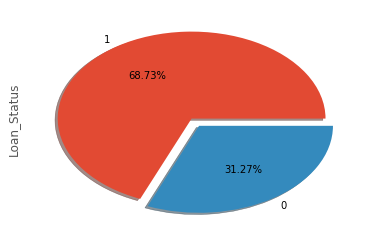

In [24]:
#Visualization in a pie chart of the label
df['Loan_Status'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.2f%%', shadow=True);

In [71]:
def makebarchart(df, column, label):
    f, ax = plt.subplots(1,2, figsize= figsize)
    sns.countplot(column, data=df, ax=ax[0])
    ax[0].set_title(column + ' Userbase Distribution')
    df.groupby(column)[label].mean().plot.bar(ax=ax[1])
    ax[1].set_title(label + ' By Gender');

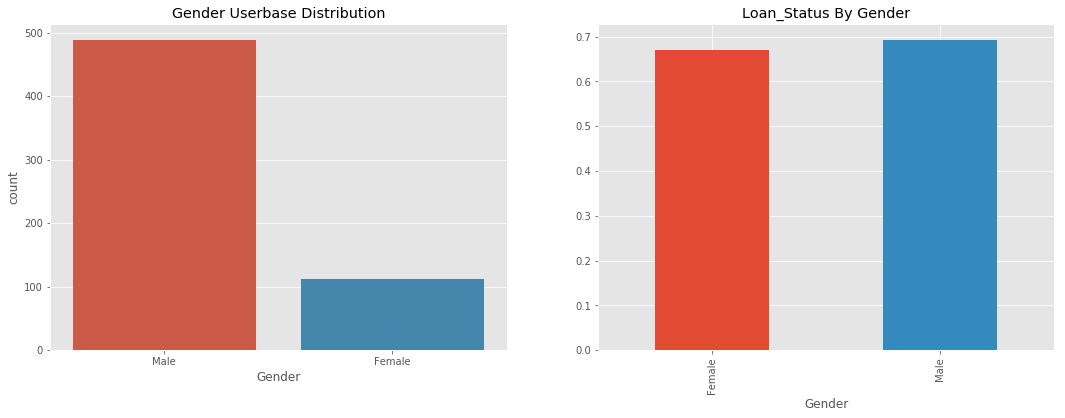

In [72]:
makebarchart(df, 'Gender', 'Loan_Status')

###### Univariate Analysis of the label

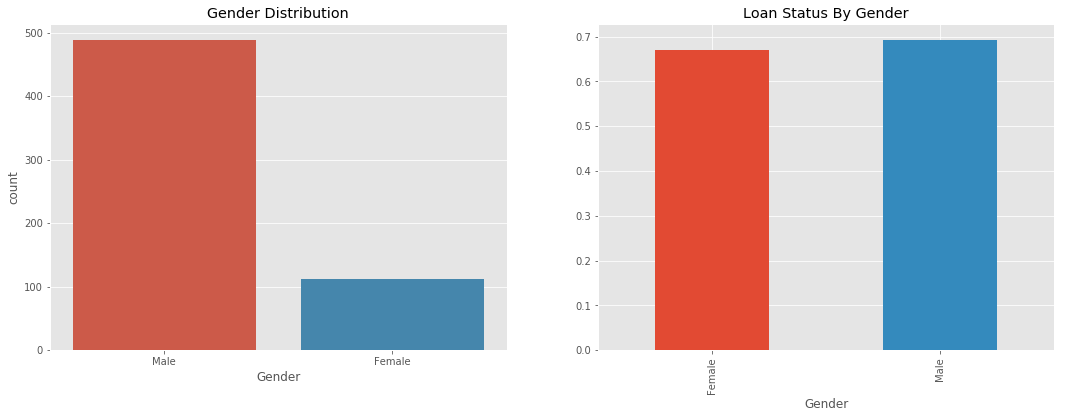

In [158]:
f, ax = plt.subplots(1,2, figsize= figsize)
sns.countplot('Gender', data=df, ax=ax[0])
ax[0].set_title('Gender Distribution')
df.groupby('Gender')['Loan_Status'].mean().plot.bar(ax=ax[1])
ax[1].set_title('Loan Status By Gender');

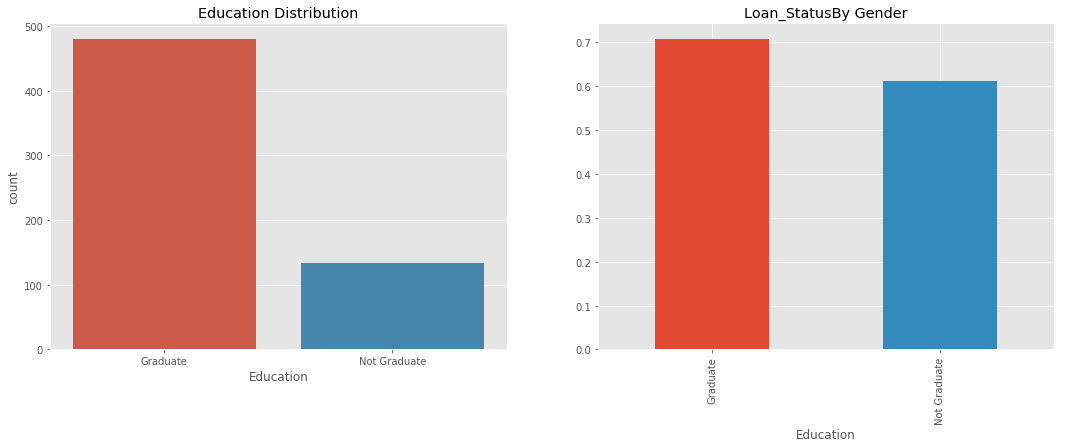

In [63]:
makebarchart(df, 'Education', 'Loan_Status')

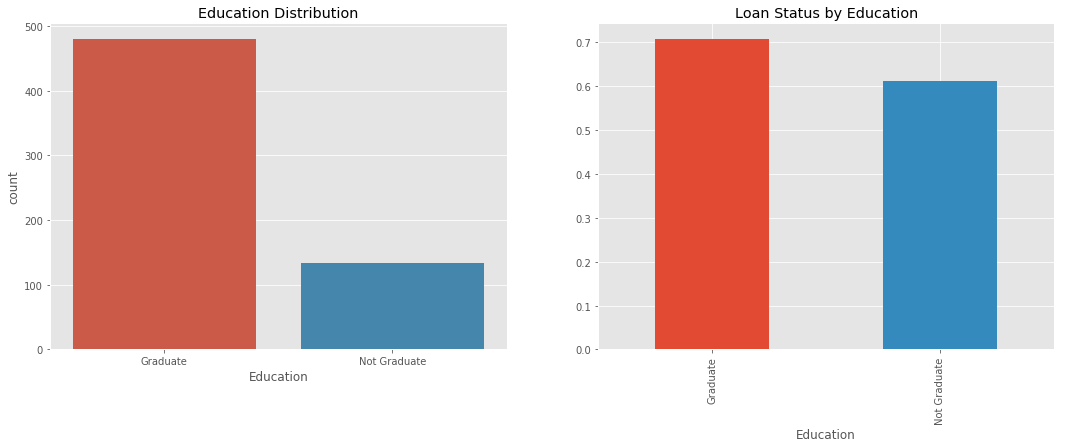

In [26]:
f, ax = plt.subplots(1,2, figsize=figsize)
sns.countplot('Education', data=df, ax=ax[0])
ax[0].set_title('Education Distribution')
df.groupby('Education')['Loan_Status'].mean().plot.bar(ax=ax[1])
ax[1].set_title('Loan Status by Education');

Text(0.5,1,'Loan Status by Credit_History')

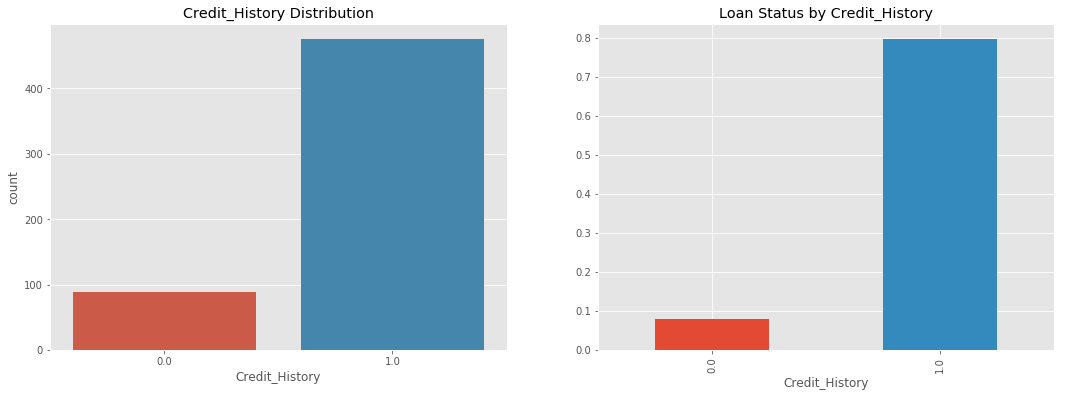

In [170]:
f,ax = plt.subplots(1,2, figsize=figsize)
sns.countplot('Credit_History', data=df, ax=ax[0])
ax[0].set_title('Credit_History Distribution')
df.groupby('Credit_History')['Loan_Status'].mean().plot.bar(ax=ax[1])

ax[1].set_title('Loan Status by Credit_History')

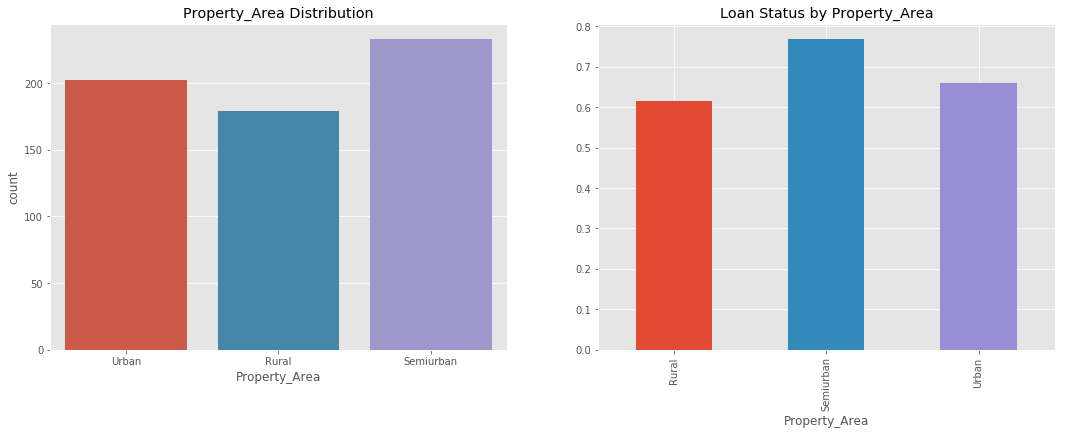

In [28]:
f,ax = plt.subplots(1,2, figsize=figsize)
sns.countplot('Property_Area', data=df, ax=ax[0])
ax[0].set_title('Property_Area Distribution')
df.groupby('Property_Area')['Loan_Status'].mean().plot.bar(ax=ax[1])
ax[1].set_title('Loan Status by Property_Area');

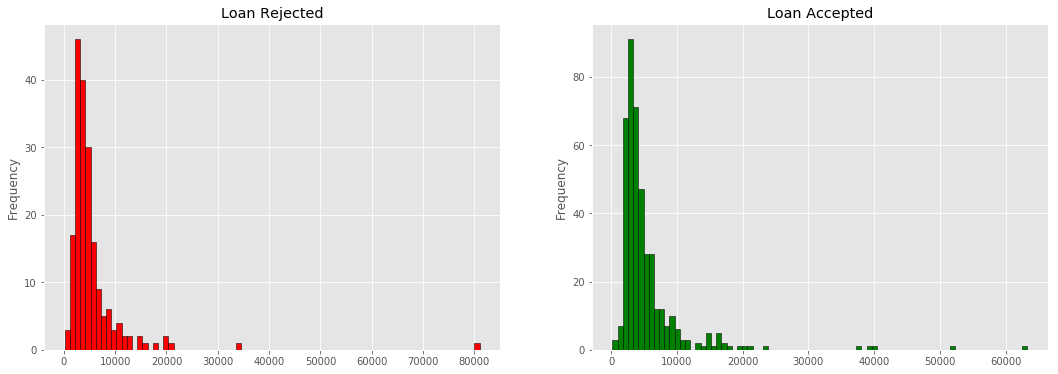

In [29]:
f,ax=plt.subplots(1,2,figsize=figsize)
df[df['Loan_Status']==0].ApplicantIncome.plot.hist(bins=80, color='r', edgecolor='black', ax=ax[0])
ax[0].set_title('Loan Rejected')
df[df['Loan_Status']==1].ApplicantIncome.plot.hist(bins=80, color='g', edgecolor='black', ax=ax[1])
ax[1].set_title('Loan Accepted');

In [189]:
def makebarchart(df, column, label):
    f, ax = plt.subplots(1,2, figsize= figsize)
    sns.countplot(column, data=df, ax=ax[0])
    ax[0].set_title(column + ' Userbase Distribution')
    df.groupby(column)[label].mean().plot.bar(ax=ax[1])
    ax[1].set_title(label + ' By ' + column);

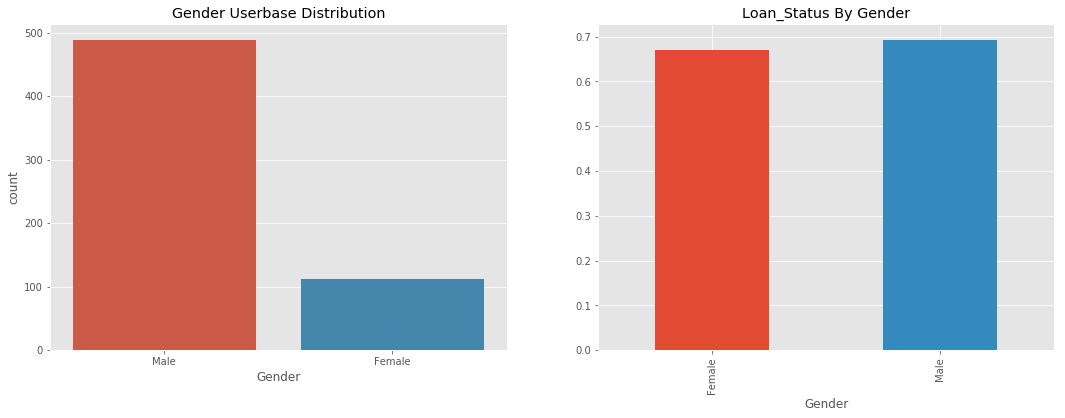

In [190]:
makebarchart(df, 'Gender', 'Loan_Status')

In [186]:
def makehistchart(df, column, label, bins):
    bins=bins # set the number of bins
    f,ax=plt.subplots(1,2,figsize=figsize)
    df[df[label]==0][column].plot.hist(bins=bins, color='r', edgecolor='black', ax=ax[0])
    ax[0].set_title('Loan Rejected')
    df[df[label]==1][column].plot.hist(bins=bins, color='g', edgecolor='black', ax=ax[1])
    ax[1].set_title('Loan Accepted')
    # overlap the two diagram for a better visulation
    f =plt.figure(figsize=figsize)
    plt.hist(df[df[label]==1][column], bins=bins, color='b', edgecolor='black', label='Loan Accepted')
    plt.hist(df[df[label]==0][column], bins=bins, color='r', edgecolor='black', label='Loan Rejected', alpha=0.8)
    plt.title(column + ' Distribution splitted by ' + label)
    plt.ylabel('Frequency'); plt.xlabel(label)
    plt.legend(loc='upper center', frameon=False, ncol=2);

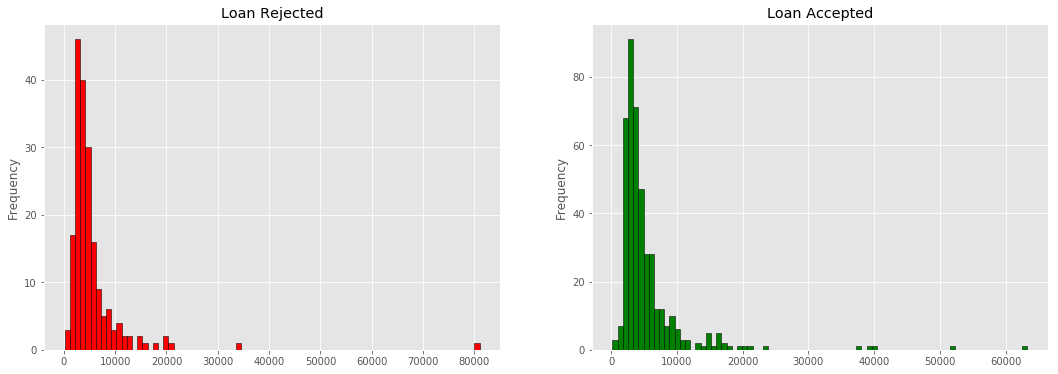

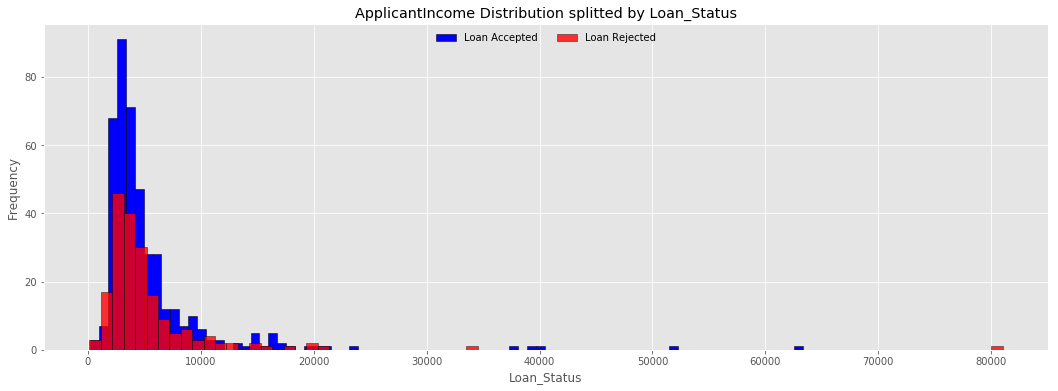

In [187]:
makehistchart(df, 'ApplicantIncome', 'Loan_Status', 80)

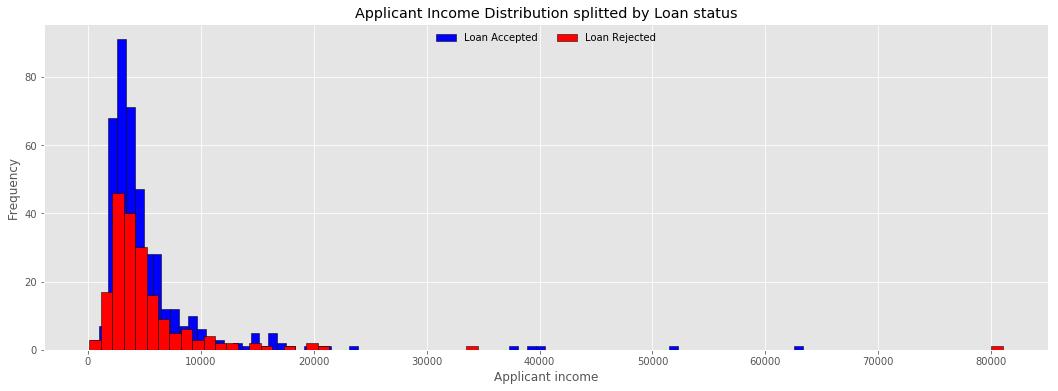

In [166]:
f =plt.figure(figsize=figsize)
plt.hist(df[df['Loan_Status']==1].ApplicantIncome, bins=80, color='b', edgecolor='black', label='Loan Accepted')
plt.hist(df[df['Loan_Status']==0].ApplicantIncome, bins=80, color='r', edgecolor='black', label='Loan Rejected')
plt.title('Applicant Income Distribution splitted by Loan status')
plt.ylabel('Frequency'); plt.xlabel('Applicant income')
plt.legend(loc='upper center', frameon=False, ncol=2);

###### EDA insights

- Gender and Education does not affect Loan status. 
- On the contrary Credit History variable show a very strong influence on the chance of receiving the loan. In fact some 80% of the people with a Credit history are able to receive thei loan, agianst less than 10% of the people without.
- Property area shows a mild influence on the label.
- Applicant income seems to exert an action too.

### Data processing for Machine Learning Analysis

###### Create Feature Matrix X

In [31]:
# slice the dataframe from the first column to the last but one
feature_names = df.columns.values[:-1]
X = df[feature_names].copy() # make a copy of the original dataframe to avoid warning error
X.shape

(614, 12)

###### Label encoding of categorical variables¶¶

In [32]:
for feature in X.select_dtypes(include = ['O']).columns.values: # loop through all the feature spaces and pick only the catvars
    X[feature] = X[feature].factorize()[0] # we encode with numeric label the catvar and assign a default value od -1 to NaN
X.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,0,0,0,0,0,0,5849,0,NaN,360.0,1.0,0
1,1,0,1,1,0,0,4583,1508,128.0,360.0,1.0,1
2,2,0,1,0,0,1,3000,0,66.0,360.0,1.0,0
3,3,0,1,0,1,0,2583,2358,120.0,360.0,1.0,0
4,4,0,0,0,0,0,6000,0,141.0,360.0,1.0,0


In [33]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
Loan_ID              614 non-null int64
Gender               614 non-null int64
Married              614 non-null int64
Dependents           548 non-null category
Education            614 non-null int64
Self_Employed        614 non-null int64
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null int32
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null int64
dtypes: category(1), float64(3), int32(1), int64(7)
memory usage: 51.2 KB


There are also some numeric variables that must be filled due to the presence of NaN

In [34]:
X['Credit_History'] = X['Credit_History'].factorize()[0]

In [35]:
X.Credit_History.value_counts()

 0    475
 1     89
-1     50
Name: Credit_History, dtype: int64

In [36]:
#Let's impute the mean value to the missing ones for both features
X['Loan_Amount_Term'].fillna(X.Loan_Amount_Term.mean(), inplace=True)
X['LoanAmount']= X['LoanAmount'].fillna(X.LoanAmount.mean())

In [37]:
#This is a caetgory we enginereed previously. Here the most sound choice to do is to fill missing values with the most frequent value
X['Dependents'] = X['Dependents'].fillna(X.Dependents.describe().top)

In [38]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
Loan_ID              614 non-null int64
Gender               614 non-null int64
Married              614 non-null int64
Dependents           614 non-null category
Education            614 non-null int64
Self_Employed        614 non-null int64
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null int32
LoanAmount           614 non-null float64
Loan_Amount_Term     614 non-null float64
Credit_History       614 non-null int64
Property_Area        614 non-null int64
dtypes: category(1), float64(2), int32(1), int64(8)
memory usage: 51.2 KB


Feature matrix full of numeric values only and showing no presence of missing values. Ready for manipulation

###### Create response vector y

In [39]:
y= df.Loan_Status
y.shape

(614,)

### Cross validation¶

The dataset size is very small, therefore we could easily expect a strong variance during the CV fase, i.e. the results to be severely influenced by the way we select the training set. Let's verify this 

In [40]:
# split data in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

### Model Selection

We will try now to select the best model to obtain predictions. The 1st model we try is:

###### Random Forest

In [41]:
rf = RandomForestClassifier(n_estimators=30, # to speed up process time and obtain acceptable results
                            n_jobs=-1,        # to exploit all cores
                            random_state=23,  # for reproducibility
                            oob_score=True)  # to exploit internal cross validation tool of RF classifier

In [42]:
# train the model
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=True, random_state=23, verbose=0, warm_start=False)

In [43]:
# calculate the accuracy of the model on training set
training_accuracy = rf.score(X_train, y_train) 
print('Accuracy of Training set = {:.4f}'.format(training_accuracy))

Accuracy of Training set = 0.9976


Training accuracy is very high, no chance of underfitting, hence we can be sure the model is no biased

In [44]:
print('Cross Validation accuracy  = {:.4f}'.format(rf.oob_score_))

Cross Validation accuracy  = 0.7713


In [45]:
# predict conversion rate on unseen data X_test
y_pred = rf.predict(X_test)
test_score = rf.score(X_test, y_test)
print('Accuracy of Testing set = {:.4f}'.format(test_score))

Accuracy of Testing set = 0.7833


Accuracy went down quite consistently to some 78%, indicating that the model is now overfitting. Before trying to come out with strategies to increase the accuracy let's check the null accuracy and classification report

In [46]:
Null_Accuracy = max(y_test.mean(), 1-y_test.mean()) 
print('Null Accuracy= {:.4f}'.format (Null_Accuracy)) # Baseline for model evaluation

Null Accuracy= 0.6453


In [47]:
print('Classification Report=\n\n',(classification_report(y_test, y_pred)))

Classification Report=

              precision    recall  f1-score   support

          0       0.82      0.50      0.62        72
          1       0.77      0.94      0.85       131

avg / total       0.79      0.78      0.77       203



In [48]:
print('Confusion Matrix =\n\n',confusion_matrix(y_test, y_pred))

Confusion Matrix =

 [[ 36  36]
 [  8 123]]


In [49]:
#Let's calculate ROC metric
y_pred_proba = rf.predict_proba(X_test)[:,1] # model predicted probability of class 1
rf_roc_auc = roc_auc_score(y_test, y_pred_proba)
print('Random Forest AUC Score =', round(rf_roc_auc,4))

Random Forest AUC Score = 0.8048


As foresaw accuracy prediction rate on unseen data decreased considerably, becasue the model parameters strongly adapted to the training set. A possible solution to limit this effect might be to cross validate the entire dataset, instead of just splitting it into two block. 

Let's use the K-fold cross validation module selecting 10 folders and trying to optimize accuracy as a metric.

###  K-fold Cross validation¶


In [50]:
cv = 10
scores = cross_val_score(rf, X, y, cv=cv, scoring='accuracy')

In [51]:
for i, score in zip(list(range(1,cv+1)),scores): # loop trough each of the folders get the score
        print("Score in folder {} is:{}".format(i, score)) 

Score in folder 1 is:0.3968253968253968
Score in folder 2 is:0.7936507936507936
Score in folder 3 is:0.7377049180327869
Score in folder 4 is:0.7540983606557377
Score in folder 5 is:0.8032786885245902
Score in folder 6 is:0.8032786885245902
Score in folder 7 is:0.8360655737704918
Score in folder 8 is:0.8524590163934426
Score in folder 9 is:0.7868852459016393
Score in folder 10 is:0.8032786885245902


In [52]:
print('Accuracy of {}-fold Cross Validation is: {:.4f} '.format(cv,(scores.mean())))

Accuracy of 10-fold Cross Validation is: 0.7568 


The mean score accuracy of the this 10-fold CV we performed did not improved, in fact it slightly diminished. 
We can exclude then that overfitting is derived from data variance. Let's investigate some other alternatives, as for example the model needs some parameter tuning to reduce overfitting and therefore improve accuracy.

We will try to optimize the usual most important parameters of Random Forest (nr. of trees, max features available at each split, minimum nr. of samples in leafs. We will approach the problem using a customizing grid search, manually testing  for each parameter a list of values we expect to be productive. 

### Hyperparameters

30 Trees
Random Forest AUC Score = 0.801

50 Trees
Random Forest AUC Score = 0.805

100 Trees
Random Forest AUC Score = 0.816

200 Trees
Random Forest AUC Score = 0.817

500 Trees
Random Forest AUC Score = 0.815

1000 Trees
Random Forest AUC Score = 0.816

2000 Trees
Random Forest AUC Score = 0.816



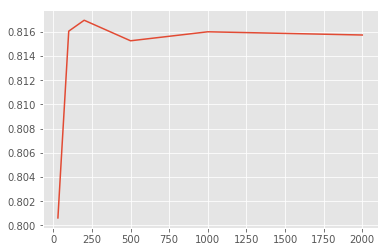

In [53]:
results =[]
n_estimators_options = [30,50,100,200,500,1000,2000]
for trees in n_estimators_options:
    model = RandomForestClassifier(trees, oob_score=True, random_state=42, n_jobs=-1 )
    model.fit(X_train, y_train)
    print( trees, 'Trees')
    y_pred_proba = model.predict_proba(X_test)[:,1]
    rf_roc_auc = roc_auc_score(y_test, y_pred_proba)
    print('Random Forest AUC Score =', round(rf_roc_auc,3))
    results.append(rf_roc_auc)
    print('')
pd.Series(results, n_estimators_options).plot();

The optimal number of trees appear to be 100. Then we set this value for this parameter and test max_feature

auto max_features
Random Forest AUC Score = 0.816

sqrt max_features
Random Forest AUC Score = 0.816

log2 max_features
Random Forest AUC Score = 0.816

0.9 max_features
Random Forest AUC Score = 0.812

0.2 max_features
Random Forest AUC Score = 0.807



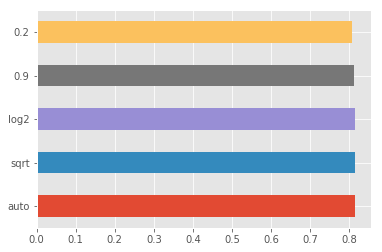

In [54]:
results =[]
max_features_options = ['auto', 'sqrt', 'log2', 0.9, 0.2]
for max_features in max_features_options:
    model = RandomForestClassifier(100, max_features=max_features, oob_score=True, random_state=42, n_jobs=-1 )
    model.fit(X_train, y_train)
    print( max_features, 'max_features')
    y_pred_proba = model.predict_proba(X_test)[:,1]
    rf_roc_auc = roc_auc_score(y_test, y_pred_proba)
    print('Random Forest AUC Score =', round(rf_roc_auc,3))
    results.append(rf_roc_auc)
    print('')
pd.Series(results, max_features_options).plot(kind='barh');

Not surprisingly the default value for this type of classifier (Auto or Sqrt) is the most performing one. We leave this one in next search, along with 100 nr. of estimators and check for the best valur for min sample leaf.

1 min_samples_leaf
Random Forest AUC Score = 0.816

2 min_samples_leaf
Random Forest AUC Score = 0.817

3 min_samples_leaf
Random Forest AUC Score = 0.805

4 min_samples_leaf
Random Forest AUC Score = 0.81

5 min_samples_leaf
Random Forest AUC Score = 0.796

6 min_samples_leaf
Random Forest AUC Score = 0.787

7 min_samples_leaf
Random Forest AUC Score = 0.78

8 min_samples_leaf
Random Forest AUC Score = 0.786

9 min_samples_leaf
Random Forest AUC Score = 0.778

10 min_samples_leaf
Random Forest AUC Score = 0.779



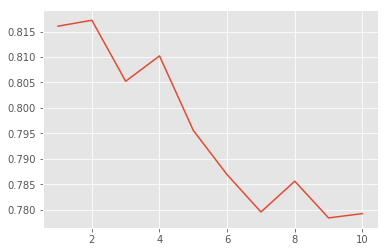

In [55]:
results =[]
min_samples_leaf_options = np.arange(1,11)
for min_samples_leaf in min_samples_leaf_options:
    model = RandomForestClassifier(100, max_features='auto', min_samples_leaf= min_samples_leaf, oob_score=True, random_state=42, n_jobs=-1 )
    model.fit(X_train, y_train)
    print( min_samples_leaf, 'min_samples_leaf')
    y_pred_proba = model.predict_proba(X_test)[:,1]
    rf_roc_auc = roc_auc_score(y_test, y_pred_proba)
    print('Random Forest AUC Score =', round(rf_roc_auc,3))
    results.append(rf_roc_auc)
    print('')
pd.Series(results, min_samples_leaf_options).plot();

Apparently the best value for this parmeter is set to two. Then we re-train the model using this best configuration we manually  came up with and we re e-evaluate the RF model tuned. We will use the same train/test split we used, in light of the fact that  k-fold CV did not delivered any improvements

In [56]:
rf = RandomForestClassifier(n_estimators=100, 
                            n_jobs=-1,        
                            random_state=23,  
                            min_samples_leaf=2)  

In [57]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=23, verbose=0, warm_start=False)

In [58]:
# calculate the accuracy of the model on training set
training_accuracy = rf.score(X_train, y_train) 
print('Accuracy of Training set = {:.4f}'.format(training_accuracy))

Accuracy of Training set = 0.9319


Not surprisingly the tune model training accuracy reduced a little bit, but that is not a big issue, considering that the main metric we are after is Test Accuracy. Let's check its variation

In [59]:
# predict conversion rate on unseen data X_test
y_pred = rf.predict(X_test)
test_score = rf.score(X_test, y_test)
print('Testing Accuracy =', test_score)

Testing Accuracy = 0.7980295566502463


As expected Testing Accuracy for this tuned model went up, when compared with the previous value (0.7833), but not as we would have hoped. Apparently this is the best this model can do with these features set.

As a side exercise and to have visualition of the actual performaces we can plot the learning curves and check the trend of testing and training accuracy. 

### Plotting Learning Curves

In [60]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(20,5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training set sizes")
    plt.ylabel("Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_error_mean = 1-np.mean(train_scores, axis=1)
    test_error_mean = 1- np.mean(test_scores, axis=1)
    plt.grid()
    plt.plot(train_sizes, train_error_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_error_mean, 'o-', color="g",
             label="Cross-validation error")

    plt.legend(loc="best")
    return plt

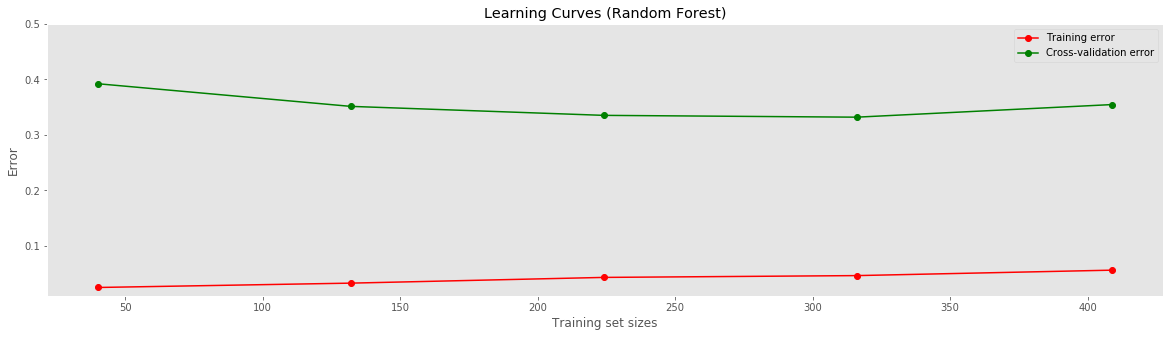

In [61]:
title = "Learning Curves (Random Forest)"
plot_learning_curve(rf, title, X, y, ylim=(0.01, 0.5), cv=None, n_jobs=-1);

The plot confirms that as the size of the training set increases the testing accuracy goes down, but with this reduced set of observations this is the best the model can do. Very likely if we could fed the model with some more observations, the model would benefit, therefore this is case where gathering more observations is an objective to pursue.

We have the last tool in our arsenal to try and improve this model performance trying to simplify it, considering that the model is overfitting at this moment and therefore is adpating to much to the complexity and particularly able to catch the signals in the data. 

The easy way to simplify a model is to reduce the number of features to the most important ones. The first step in this strategy is to pick the most important features and use just them to train the model, This is easy done trough the feature importances attributes made it available with *feature_importances_* attribute

### Feature importances

In [62]:
#zip the array and sort it
for feature in sorted(list(zip(rf.feature_importances_, X)), reverse=True):
    print(feature)

(0.288408968703035, 'Credit_History')
(0.14993165575271714, 'ApplicantIncome')
(0.14134197704957613, 'LoanAmount')
(0.14094265844548423, 'Loan_ID')
(0.08349775435195596, 'CoapplicantIncome')
(0.057878505053891784, 'Property_Area')
(0.03689712685958087, 'Loan_Amount_Term')
(0.025477865649147797, 'Married')
(0.025036367964599484, 'Dependents')
(0.019675865006529337, 'Gender')
(0.015696644522379642, 'Self_Employed')
(0.015214610641102626, 'Education')


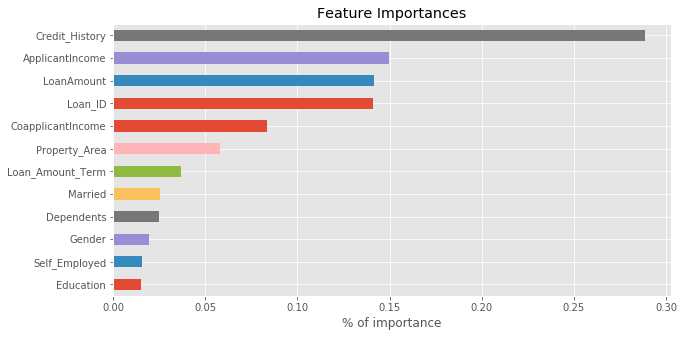

In [63]:
# Chart a visual representation
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values().plot(kind='barh', figsize=(10,5))
plt.title('Feature Importances'), plt.xlabel('% of importance');

In [64]:
# create a list of less relevan variable to be dropped in the model
irrelevant_features = ['Education','Self_Employed', 'Gender', 'Dependents','Married', 'Loan_Amount_Term', 'Loan_ID']

In [65]:
X_new = X.drop(irrelevant_features, axis=1) # Create the new dataset we want to adopt
X_new.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Property_Area
0,5849,0,146.412162,0,0
1,4583,1508,128.000000,0,1
2,3000,0,66.000000,0,0
3,2583,2358,120.000000,0,0
4,6000,0,141.000000,0,0


In [119]:
# split data in train and test set
X_new_train, X_new_test, y_train, y_test = train_test_split(X_new, y, random_state=42, test_size=0.33)

In [245]:
#let's use the same tune model we have identified as the best one
rf = RandomForestClassifier(n_estimators=100, 
                            n_jobs=-1,        
                            random_state=23,  
                            min_samples_leaf=2)  

In [246]:
#train the model with these reduced number of features
rf.fit(X_new_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=23, verbose=0, warm_start=False)

In [247]:
# calculate the accuracy of the model on training set
training_accuracy = rf.score(X_new_train, y_train) 
print('Accuracy of Training set = {:.4f}'.format(training_accuracy))

Accuracy of Training set = 0.9124


In [248]:
print('New Testing Accuracy after feature reduction is = {:.4f}'.format(rf.score(X_new_test, y_test)))

New Testing Accuracy after feature reduction is = 0.7734


In [244]:
print(classification_report(y_test, rf.predict(X_new_test)))

             precision    recall  f1-score   support

          0       0.81      0.47      0.60        72
          1       0.76      0.94      0.84       131

avg / total       0.78      0.77      0.76       203



In [249]:
print(confusion_matrix(y_test, rf.predict(X_new_test)))

[[ 34  38]
 [  8 123]]


Unfortunately no improvement has been shown by this feature reduction, threfore we can conclude that some 80% accuracy is the best we can do with Random Forest model using these dataset.

Let's try another tree-based model as GBT, to verify if is a better fit for our problem

In [77]:
X_log = X_new.drop('LoanAmount', 1); X_log.head()

,ApplicantIncome,CoapplicantIncome,Credit_History,Property_Area
0,5849,0,0,0
1,4583,1508,0,1
2,3000,0,0,0
3,2583,2358,0,0
4,6000,0,0,0


In [78]:
#let' split in train/test set this dataset
X_log_train, X_log_test, y_train, y_test = train_test_split(X,y, test_size=.3)

In [79]:
lr= LogisticRegression(C=2) # instantiate the classifier with a Regularization parameter C equal to 2)
lr.fit(X_log_train, y_train)
print('Train Acc:', lr.score(X_log_train, y_train))
print('Test Acc:', lr.score(X_log_test, y_test))

Train Acc: 0.8041958041958042
Test Acc: 0.8108108108108109


To accelerate convergence of the algorithm is better to standardize the data to homogenize the ranges, transforming them in an equivalent dataset with mean= 0 and σ=1

In [80]:
from sklearn.preprocessing import StandardScaler # import classifier
standard_scaler = StandardScaler() # instantiate
X_train_scaled = standard_scaler.fit_transform(X_log_train) # scale the training set
X_test_scaled = standard_scaler.fit_transform(X_log_test) # scale the testing set
lr.fit(X_train_scaled, y_train) # train the classifier
print('Train Acc:', lr.score(X_train_scaled, y_train)) 
print('Test Acc:', lr.score(X_test_scaled, y_test))

Train Acc: 0.8065268065268065
Test Acc: 0.8162162162162162


Once again we see that **test set performance does not move higher than 80%**. 

# Conclusions

In [236]:
df.groupby(['Credit_History','Loan_Status'])['Loan_ID'].size().unstack()

Loan_Status,0,1
Credit_History,,
0.0,82,7
1.0,97,378


In [235]:
df.loc[(df.Credit_History==0) & (df.Loan_Status==1), :]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
122,LP001431,Female,No,0,Graduate,No,2137,8980,137.0,360.0,0.0,Semiurban,1
155,LP001536,Male,Yes,NaN,Graduate,No,39999,0,600.0,180.0,0.0,Semiurban,1
201,LP001677,Male,No,2,Graduate,No,4923,0,166.0,360.0,0.0,Semiurban,1
267,LP001882,Male,Yes,NaN,Graduate,No,4333,1811,160.0,360.0,0.0,Urban,1
326,LP002068,Male,No,0,Graduate,No,4917,0,130.0,360.0,0.0,Rural,1
453,LP002449,Male,Yes,0,Graduate,No,2483,2466,90.0,180.0,0.0,Rural,1
527,LP002706,Male,Yes,1,Not Graduate,No,5285,1430,161.0,360.0,0.0,Semiurban,1


In [237]:
y_pred = rf.predict(X_new_test)

In [238]:
b = pd.concat([X_new_test, pd.DataFrame(y_test), pd.DataFrame(y_pred, index=X_new_test.index, columns=['Loan Status predicted']) ],  1)
b.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Property_Area,Loan_Status,Loan Status predicted
350,9083,0,228.0,0,2,1,1
377,4310,0,130.0,-1,2,1,1
163,4167,1447,158.0,0,1,1,1
609,2900,0,71.0,0,1,1,0
132,2718,0,70.0,0,2,1,1


In [257]:
errors = b.loc[b.Loan_Status!=b['Loan Status predicted'],:]
errors

,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Property_Area,Loan_Status,Loan Status predicted
609,2900,0,71.000000,0,1,1,0
340,2647,1587,173.000000,0,1,0,1
77,1000,3022,110.000000,0,0,0,1
209,3418,0,127.000000,0,2,0,1
610,4106,0,40.000000,0,1,1,0
148,10000,1666,225.000000,0,1,0,1
457,3708,2569,173.000000,0,0,0,1
82,1378,1881,167.000000,0,0,0,1
319,10000,0,155.000000,0,1,0,1
30,4166,3369,201.000000,-1,0,0,1


In [250]:
b.loc[(b.Credit_History==0) & (b.Loan_Status==1), :]

,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Property_Area,Loan_Status,Loan Status predicted
350,9083,0,228.000000,0,2,1,1
163,4167,1447,158.000000,0,1,1,1
609,2900,0,71.000000,0,1,1,0
132,2718,0,70.000000,0,2,1,1
578,1782,2232,107.000000,0,1,1,1
316,3717,0,120.000000,0,2,1,1
2,3000,0,66.000000,0,0,1,1
462,3015,2188,153.000000,0,1,1,1
109,2071,754,94.000000,0,2,1,1
322,3601,1590,146.412162,0,1,1,1


In [305]:
data= df.copy()

In [306]:
X['ratio'] = (df.LoanAmount*1000/df.Loan_Amount_Term)/(df.ApplicantIncome+df.CoapplicantIncome)*100

In [307]:
X.head()

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,ratio
0,0,0,0,0,0,0,0,NaN
1,0,1,1,0,0,0,1,5.837392
2,0,1,0,0,1,0,0,6.111111
3,0,1,0,1,0,0,0,6.746273
4,0,0,0,0,0,0,0,6.527778


In [309]:
#X.drop(['Loan_ID', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'], 1, inplace=True)

In [310]:
X['ratio']= X.ratio.fillna(X.ratio.mean())

In [312]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 8 columns):
Gender            614 non-null int64
Married           614 non-null int64
Dependents        614 non-null category
Education         614 non-null int64
Self_Employed     614 non-null int64
Credit_History    614 non-null int64
Property_Area     614 non-null int64
ratio             614 non-null float64
dtypes: category(1), float64(1), int64(6)
memory usage: 34.4 KB


In [313]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

In [314]:
X_train.shape

(411, 8)

In [335]:
rf = RandomForestClassifier(n_estimators=100, # to speed up process time and obtain acceptable results
                            n_jobs=-1,        # to exploit all cores
                            random_state=23,  # for reproducibility
                            oob_score=True)  # to exploit internal cross validation tool of RF classifier

In [336]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=23, verbose=0, warm_start=False)

In [337]:
rf.score(X_train, y_train)

1.0

In [338]:
rf.score(X_test, y_test)

0.7783251231527094

In [339]:
y_pred = rf.predict(X_test)

In [340]:
print('Classification Report=\n\n',(classification_report(y_test, y_pred)))

Classification Report=

              precision    recall  f1-score   support

          0       0.80      0.50      0.62        72
          1       0.77      0.93      0.84       131

avg / total       0.78      0.78      0.76       203



In [345]:
b = pd.concat([X_test, pd.DataFrame(y_test), pd.DataFrame(y_pred, index=X_test.index, columns=['Loan Status predicted']) ],  1)
b.head(50)

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,ratio,Loan_Status,Loan Status predicted
350,0,1,0,0,0,0,2,6.972733,1,1
377,0,1,0,0,0,-1,2,8.378448,1,1
163,0,1,2,0,0,0,1,7.817757,1,1
609,1,0,0,0,0,0,1,6.800766,1,1
132,0,0,0,0,0,0,2,7.153953,1,1
578,0,1,1,0,0,0,1,7.404639,1,1
316,0,1,2,0,0,0,2,8.967806,1,1
2,0,1,0,0,1,0,0,6.111111,1,1
340,0,1,0,1,0,0,1,11.349919,0,1
77,0,1,1,0,1,0,0,7.597105,0,1


In [344]:
errors = b.loc[b.Loan_Status!=b['Loan Status predicted'],:]
errors

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,ratio,Loan_Status,Loan Status predicted
340,0,1,0,1,0,0,1,11.349919,0,1
77,0,1,1,0,1,0,0,7.597105,0,1
209,0,0,0,0,0,0,2,10.321175,0,1
577,0,0,0,0,0,0,0,5.119899,1,0
457,0,1,0,0,0,0,0,7.655816,0,1
82,1,1,2,0,0,0,0,14.234087,0,1
319,0,1,1,0,1,0,1,4.305556,0,1
131,0,0,0,0,0,0,0,5.213177,1,0
30,0,1,1,0,-1,-1,0,7.409865,0,1
449,0,0,1,1,1,-1,2,12.242584,0,1
